### BRAIN TUMOR CLASSIFICATION

#### 1. IMPORT LIBRARIES

In [1]:
# Step-1: Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

#### 2. DATA PREPROCESSING, EDA

In [3]:
train_path = r"C:\Users\srira\Downloads\912\BT DATASET\Training"
test_path = r"C:\Users\srira\Downloads\912\BT DATASET\Testing"

In [4]:
# EDA: Count number of images per class
def count_images_per_class(path):
    class_counts = {}
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            class_counts[cls] = len(os.listdir(cls_path))
    return class_counts

train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

print("Training set distribution:", train_counts)
print("Test set distribution:", test_counts)

Training set distribution: {'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395, 'pituitary_tumor': 827}
Test set distribution: {'glioma_tumor': 100, 'meningioma_tumor': 115, 'no_tumor': 105, 'pituitary_tumor': 74}


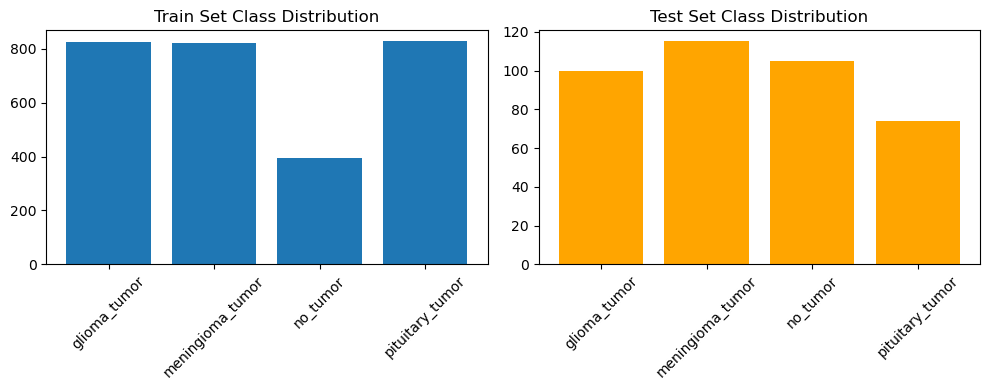

In [5]:
# Plotting class distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Train Set Class Distribution")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(test_counts.keys(), test_counts.values(), color='orange')
plt.title("Test Set Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

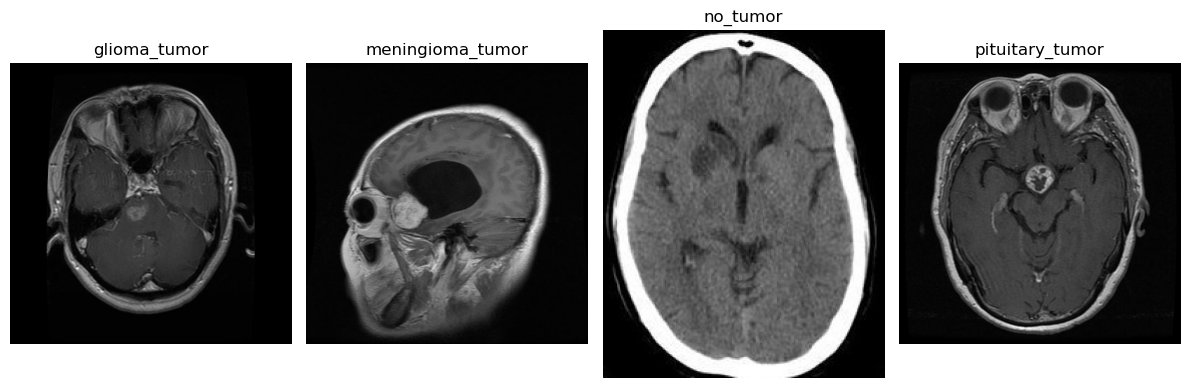

In [6]:
# Visualize sample images
import random
import cv2

def show_samples(data_path):
    plt.figure(figsize=(12, 6))
    class_names = os.listdir(data_path)
    for i, class_name in enumerate(class_names):
        img_list = os.listdir(os.path.join(data_path, class_name))
        img_path = os.path.join(data_path, class_name, random.choice(img_list))
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(class_names), i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_path)

#### 3. MODEL BUILDING

In [7]:
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [8]:
# Load DenseNet-169 base model
base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
base_model.trainable = False  # freeze base layers

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 12,649,540 (48.25 MB)

 Trainable params: 6,660 (26.02 KB)

 Non-trainable params: 12,642,880 (48.23 MB)

#### 4. MODEL TRAINING

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

C:\Users\srira\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.3745 - loss: 1.5822 - val_accuracy: 0.5969 - val_loss: 0.9237
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.6431 - loss: 0.8619 - val_accuracy: 0.6457 - val_loss: 0.7599
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.7073 - loss: 0.7214 - val_accuracy: 0.7086 - val_loss: 0.6815
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.7472 - loss: 0.6197 - val_accuracy: 0.7260 - val_loss: 0.6519
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.7707 - loss: 0.5800 - val_accuracy: 0.7627 - val_loss: 0.5977
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.8068 - loss: 0.5142 - val_accuracy: 0.7452 - val_loss: 0.6236
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8132 - loss: 0.4829 - val_accuracy: 0.7818 - val_loss: 0.5991
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.8108 - loss: 0.5026 - val_accuracy: 0.7696 - v

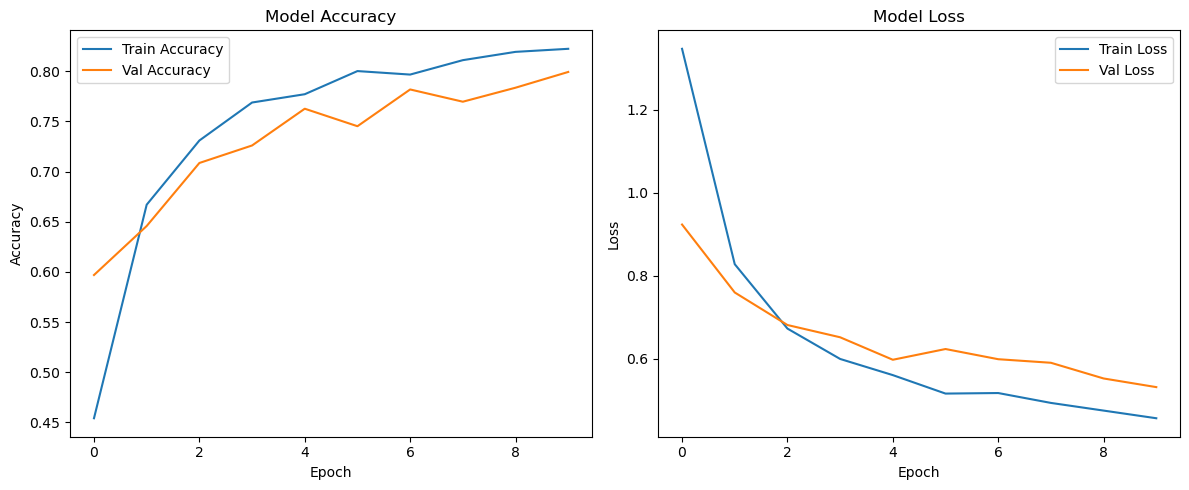

In [10]:
# Plot Accuracy & Loss
def plot_history(hist):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [11]:
import keras

In [12]:
model.save('tumor_model.keras')

In [13]:
from tensorflow.keras.models import load_model

model1 = load_model('tumor_model.keras')

#### 5. MODEL EVALUATION

In [14]:
# Predict
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

394/394 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step


In [16]:
# Metrics
print("Accuracy:", accuracy_score(y_true, y_pred_classes))
print("Precision:", precision_score(y_true, y_pred_classes, average='weighted'))
print("Recall:", recall_score(y_true, y_pred_classes, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred_classes, average='weighted'))

Accuracy: 0.6091370558375635
Precision: 0.6191515829548491
Recall: 0.6091370558375635
F1 Score: 0.5931366589552313


In [17]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.64      0.32      0.43       100
meningioma_tumor       0.59      0.66      0.63       115
        no_tumor       0.58      0.84      0.68       105
 pituitary_tumor       0.69      0.59      0.64        74

        accuracy                           0.61       394
       macro avg       0.63      0.60      0.59       394
    weighted avg       0.62      0.61      0.59       394



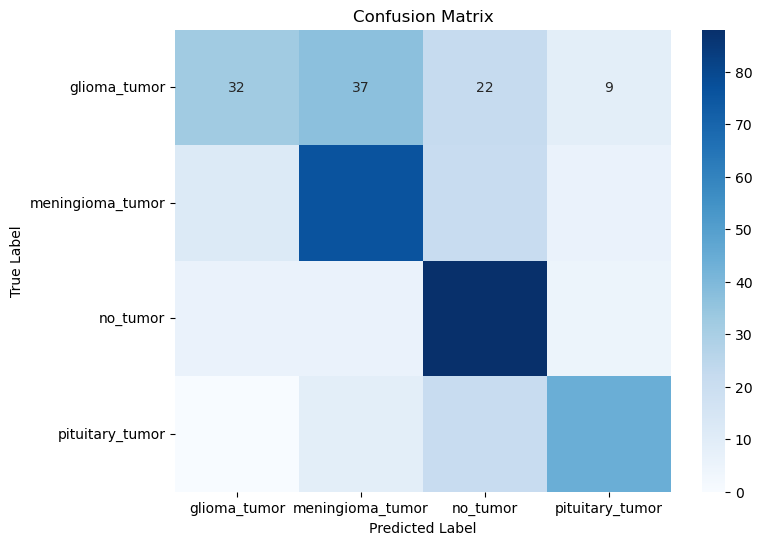

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()